# discrete

> Discrete Inference: helping a trash can robot reason about its world.


This notebook contains some utility functions for discrete inference, primarily for use in [Chapter 2  of the book](https://www.roboticsbook.org/S20_sorter_intro.html).

In [ ]:
#| default_exp discrete

In [ ]:
#| export 
from dataclasses import dataclass
from typing import Callable, Iterable
import gtsam

In [ ]:
#| hide
from fastcore.test import test_eq
from IPython.core.display import HTML

## DiscretePrior

`DiscretePrior` is something that was previously defined here but is now built into GTSAM as `DiscreteDistribution`:


In [ ]:
from gtbook.display import show

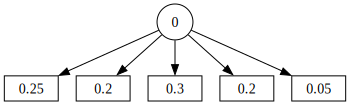

In [ ]:
C = 0, 5  # A key is an identifier (0 in this example) and a cardinality (e.g., 5)
prior = gtsam.DiscreteDistribution(C, "25/20/30/20/5")
test_eq(prior.empty(), False)

# TODO: this does not support key formatting yet, just shows the key (0 in this case)
show(prior)

In [ ]:
prior_probability_for_3 = prior(3)
test_eq(prior_probability_for_3, 0.2)

## Variables


We would like to make it easier for people to create discrete variables, with a meaningful name, and meaningful strings associated with discrete values. Below is it possible design:


In [ ]:
# | export

DiscreteKey = tuple[int, int]


@dataclass
class DiscreteVariable:
    name: str
    domain: list[str]


class Variables:
    """A problem domain for discrete variables."""

    BINARY = ["false", "true"]

    def __init__(self):
        """Default constructor"""
        self._variables: dict[DiscreteVariable] = {}

    def size(self):
        """Return number of variables defined."""
        return len(self._variables)

    def discrete(self, name: str, domain: list[str]) -> DiscreteKey:
        """Create a variable with given name and discrete domain of named values.

        Args:
            name (str): name of the variable.
            domain (list[str]): names for the different values.

        Returns:
            DiscreteKey, i.e., (gtsam.Key, cardinality)
        """
        discreteKey = len(self._variables), len(domain)
        self._variables[discreteKey[0]] = DiscreteVariable(name, domain)
        return discreteKey

    def discrete_series(
        self: "Variables",
        character: str,
        indices: Iterable[int],
        domain: list[str],
    ) -> dict[int, DiscreteKey]:
        """Create several discrete variables with Symbol names.

        Args:
            character (str): a single character.
            indices: (Iterable[int]): a set of integer indices.
            domain (list[str]): names for the different values.

        Returns:
            dict[int, DiscreteKey], i.e., [(gtsam.Key, cardinality)]
        """
        assert len(character) == 1, "discrete_series: requires character only"
        n = len(domain)

        def make_key(index):
            symbol = gtsam.Symbol(character, index)
            key = symbol.key()
            name = symbol.string()
            self._variables[key] = DiscreteVariable(name, domain)
            return (key, n)

        return {index: make_key(index) for index in indices}

    def binary(self: "Variables", name: str) -> DiscreteKey:
        """Create a binary variable with given name.

        Args:
            name (str): name of the variable.

        Returns:
            DiscreteKey, i.e., (gtsam.Key, cardinality)
        """
        return self.discrete(name, self.BINARY)

    def name(self, discreteKey: DiscreteKey) -> str:
        """Return name of variable with given discreteKey.

        Args:
            discreteKey (DiscreteKey): (gtsam.Key, cardinality)

        Returns:
            str: name of the variable.
        """
        return self._variables[discreteKey[0]].name

    def domain(self, discreteKey: DiscreteKey):
        """Return domain of variable with given discreteKey.

        Args:
            discreteKey (DiscreteKey): (gtsam.Key, cardinality)

        Returns:
            str: domain of the variable.
        """
        return self._variables[discreteKey[0]].domain

    def assignment(
        self: "Variables", map: dict[DiscreteKey, str]
    ) -> gtsam.DiscreteValues:
        """Create a GTSAM assignment of keys to values.

        Args:
            map (dict[DiscreteKey, str]): map from discrete keys to values.

        Returns:
            gtsam.DiscreteValues: the GTSAM equivalent.
        """
        values = gtsam.DiscreteValues()
        for discreteKey, value in map.items():
            domain = self.domain(discreteKey)
            assert (
                value in domain
            ), f"Specified value '{value}' not found in domain of '{self.name(discreteKey)}'. Allowed values are {domain}."
            values[discreteKey[0]] = domain.index(value)
        return values

    def keyFormatter(self: "Variables") -> Callable:
        """Return a lambda that can be used as KeyFormatter in GTSAM"""
        return lambda key: self._variables[key].name

    def names(self: "Variables") -> dict[int, list[str]]:
        """Return a names dictionary that is used by GTSAM markdown methods"""
        return {key: var.domain for (key, var) in self._variables.items()}

    def values_markdown(
        self: "Variables", assignment: gtsam.DiscreteValues
    ) -> str:
        """Render a DiscreteValues instance as markdown.

        Args:
                assignment (gtsam.DiscreteValues): the values to render.

        Returns:
                str: a markdown string.
        """
        return gtsam.markdown(assignment, self.keyFormatter(), self.names())

    def values_html(self: "Variables", assignment: gtsam.DiscreteValues) -> str:
        """Render a DiscreteValues instance as html.

        Args:
                assignment (gtsam.DiscreteValues): the values to render.

        Returns:
                str: a html string.
        """
        return gtsam.html(assignment, self.keyFormatter(), self.names())

    def _repr_html_(self: "Variables"):
        """An html representation"""
        # Print out preamble.
        ss = "<div>\n<table class='Variables'>\n  <thead>\n"

        # Print out header row.
        ss += "    <tr><th>Variable</th><th>Domain</th></tr>\n"

        # Finish header and start body.
        ss += "  </thead>\n  <tbody>\n"

        # Print out all rows.
        for variable in self._variables.values():
            ss += "    <tr>"
            ss += "<th>" + variable.name + "</th><td>"
            for value in variable.domain[:-1]:
                ss += value + ", "
            ss += variable.domain[-1]
            ss += "</td>"
            ss += "</tr>\n"
        ss += "  </tbody>\n</table>\n</div>"
        return ss


### Creating discrete variables

Here is an example:
- we first create the `variables` instance
- then define a new discrete category using the `discrete` method
- we then check that it has a `name` and a `domain`

In [ ]:
variables = Variables()
categories = ["cardboard", "paper", "can", "scrap metal", "bottle"]
Category = variables.discrete("Category", categories)

test_eq(variables.name(Category), "Category")
test_eq(variables.domain(Category), categories)

Binary variables are supported as a special case:

In [ ]:
Conductivity = variables.binary("Conductivity")
test_eq(variables.domain(Conductivity), ["false", "true"])

### Assignments

Providing the domains to the `Variables` data structure also makes it easy to create an **assignment**. An assignment, which has the type `DiscreteValues` in GTSAM, is a mapping from discrete keys to discrete values.

In [ ]:
assignment = variables.assignment({Category: "can"})
test_eq(isinstance(assignment, gtsam.DiscreteValues), True)
test_eq(assignment[C[0]], categories.index("can"))

### Rendering assignments

We also create a markdown renderer for `DiscreteValues` , awaiting the ability of pybind11 to wrap classes inherited from STL containers:

We have the functionality to provide a key formatter

In [ ]:
keyFormatter = variables.keyFormatter()
test_eq(keyFormatter(Category[0]), "Category")

We can also create a names dictionary that allows our rendering code to retrieve the domain for a given key:


In [ ]:
names = variables.names()
test_eq(isinstance(names, dict), True)
test_eq(len(names), 2)
test_eq(names, {0: ['cardboard', 'paper', 'can', 'scrap metal', 'bottle'], 1: ['false', 'true']})

With these 2 in hand, we could create a markdown renderer:

In [ ]:
test_eq(
    variables.values_markdown(assignment),
    "|Variable|value|\n|:-:|:-:|\n|Category|can|\n",
)

And HTML:

In [ ]:
HTML(variables.values_html(assignment))

Variable,value
Category,can


### Series of discrete variables

As of version `0.0.14` , we also support generating a set of discrete keys with integer indices, to support reasoning over time:


In [ ]:
n = variables.size()

# add 5 variables
states = variables.discrete_series('s', range(1,5), ["no", "yes"])
test_eq(variables.size(), n+4)

# calling twice should not add any more
states = variables.discrete_series('s', range(1,5), ["no", "yes"])
test_eq(variables.size(), n+4)

test_eq(variables.name(states[1]), "s1")
test_eq(variables.domain(states[1]), ["no", "yes"])

In [ ]:
n = variables.size()

# expand range
states = variables.discrete_series('s', range(9,10), ["no", "yes"])
test_eq(variables.size(), n+1)
test_eq(variables.name(states[9]), "s9")

### Rendering all variables defined

It would be nice to inspect a `Variables` instance easily in a notebook, and we can easily support this by supplying an HTML representation::

In [ ]:
variables

Variable,Domain
Category,"cardboard, paper, can, scrap metal, bottle"
Conductivity,"false, true"
s1,"no, yes"
s2,"no, yes"
s3,"no, yes"
s4,"no, yes"
s9,"no, yes"
